### Imports & Standard Procedure

In [10]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# RMSE and R^2 
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# XGB regressor
from sklearn.ensemble import RandomForestRegressor as rfr

# surpress warnings
import warnings
warnings.filterwarnings("ignore", message="No supported index is available", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

pd.set_option('display.max_columns', None)

# Show full width of each column
pd.set_option('display.max_colwidth', None)


### Read Data

In [2]:
df = pd.read_csv("../Stats 170 Market Hotness/Datasets/models_dataset.csv", low_memory=False) 

### Setup Train Test Split

In [13]:
features = ['prior_dom',
             'prior_salelistratio', 'cntycd',
             #'med_yearbuilt', 'med_buildingareatotal',
             #'med_FEDFUNDS', 'med_propertytax', 'med_unemploymentrate', 'med_hpi', 'med_CPI', 'med_totalRevenues',
             #'med_estimatedPopulation', 'med_revenuePerCapita'
             ]

# Set up Train - Test - Split

df_rf = df.copy()

# Ensure 'date' is datetime
df_rf['date'] = pd.to_datetime(df['date'])

for col in ['med_unemploymentrate', 'med_hpi', 'med_totalRevenues', 
            'med_estimatedPopulation', 'med_revenuePerCapita', 'hotness_index']:
    
    # Try filling with county-level median
    df_rf[col] = df_rf.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    df_rf[col] = df_rf[col].fillna(df_rf[col].median())


# Filter to Feb 2, 2020 – Feb 2, 2025
rfr_data = df_rf[
    (df_rf['date'] >= '2020-02-02') & 
    (df_rf['date'] <= '2025-02-02')
].sort_values('date')

# train test split 
split_idx = int(len(rfr_data) * 0.8)

print(split_idx)
train = rfr_data.iloc[:split_idx]

test = rfr_data.iloc[split_idx:]

# Set date as index (optional)
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

# Endogenous and exogenous variables 
y_train = train['hotness_index']
X_train = train[features]


y_test = test['hotness_index']
X_test = test[features]

1788


### Fitting Random Forest with Optimal Parameters

In [14]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

tscv = TimeSeriesSplit(n_splits=5)

rf = rfr(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict
rf_preds = best_rf.predict(X_test)
rf_rmse = root_mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print("Best Params:", grid_search.best_params_)
print(f"RMSE: {rf_rmse:.4f}")
print(f"R²: {rf_r2:.4f}")

Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 6.0457
R²: 0.6020


With all features: 
- Random Forest RMSE: 5.4567
- Random Forest R²:   0.6758

With only priors: 
- Random Forest RMSE: 6.0449
- Random Forest R²:   0.6021


In [15]:
# Fit the Gradient Boosting Regressor
rfr1 = rfr(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    min_samples_leaf=2,
    min_samples_split=2
)
rfr1.fit(X_train, y_train)

# Predict and evaluate
preds = rfr1.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²:   {r2:.4f}")

Random Forest RMSE: 6.0449
Random Forest R²:   0.6021


/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_2888/4012722183.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['date'] = pd.to_datetime(df_clean['date'])


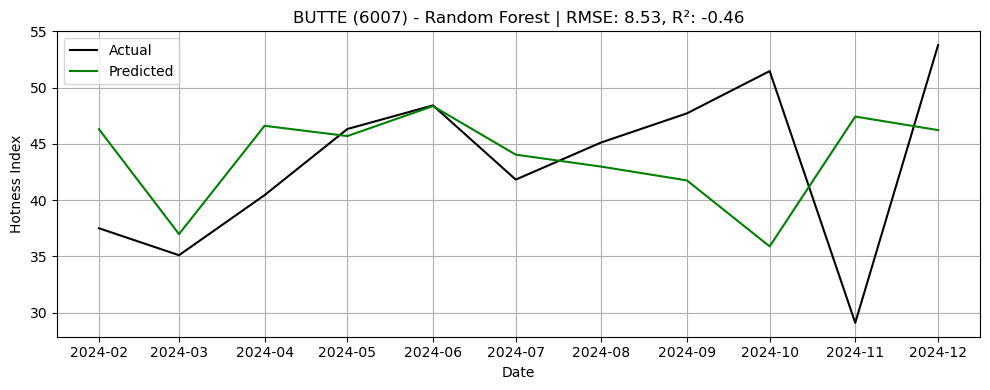

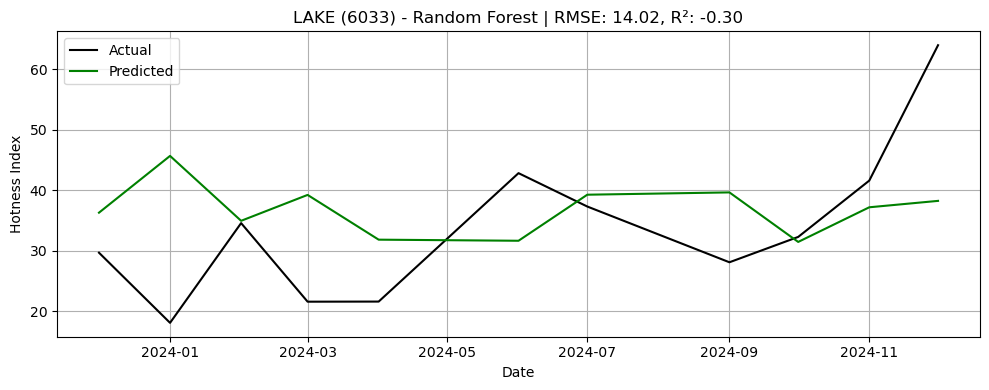

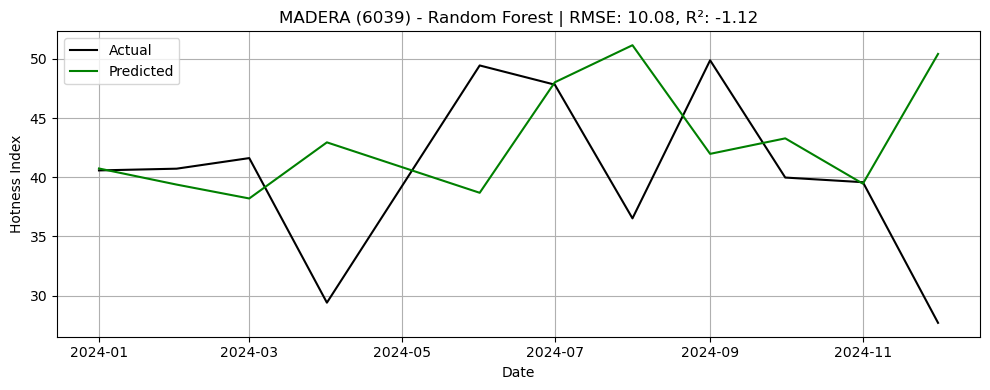

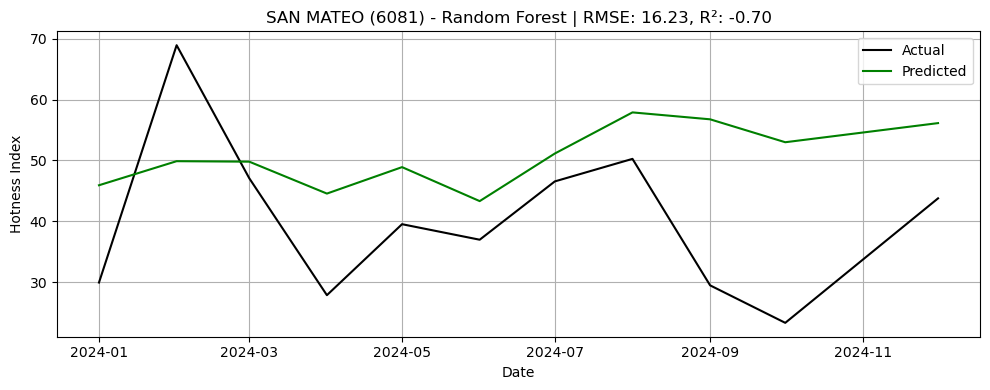

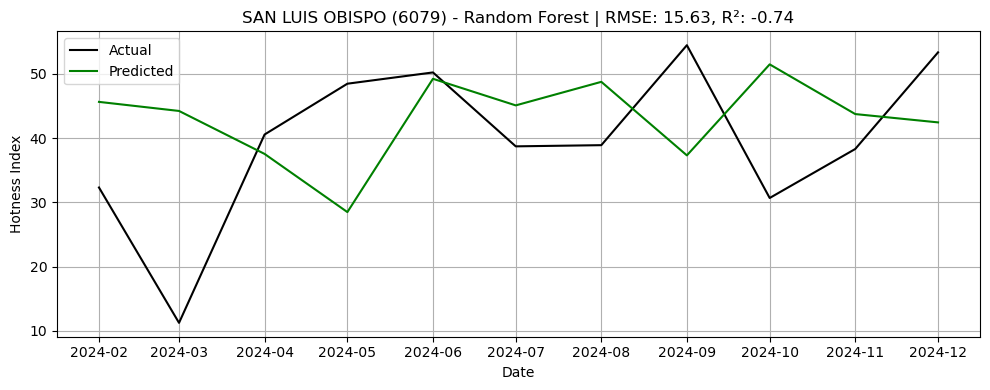

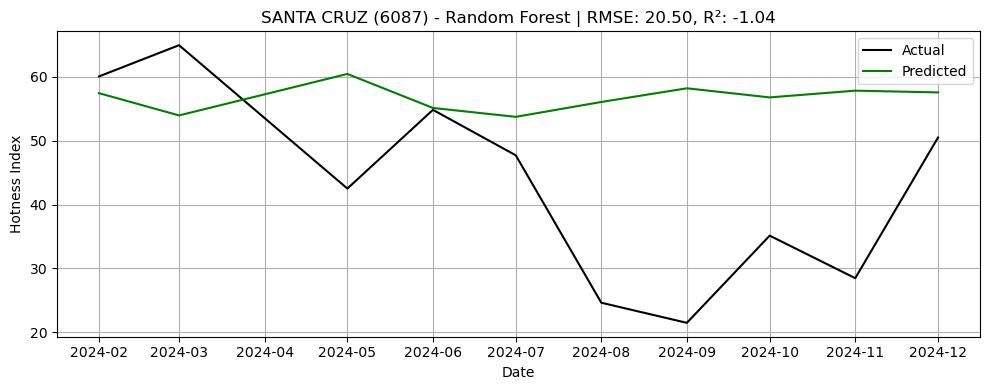

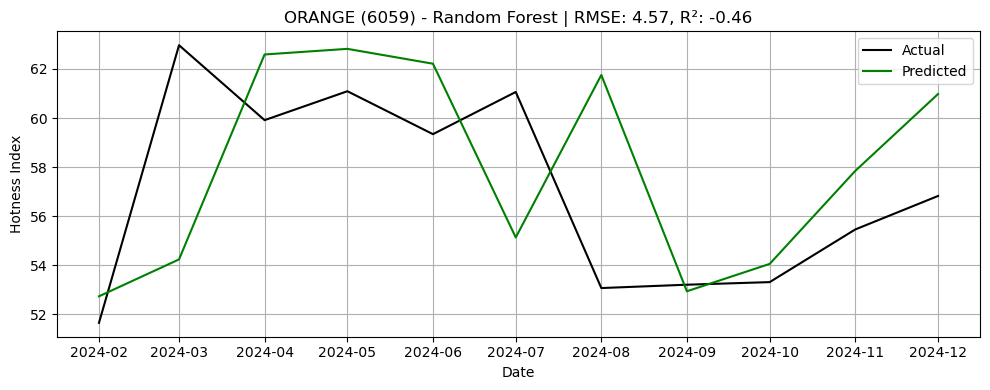

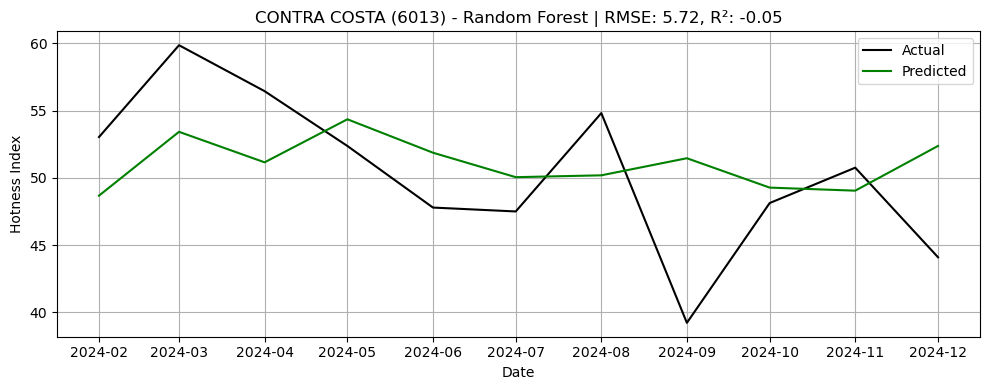

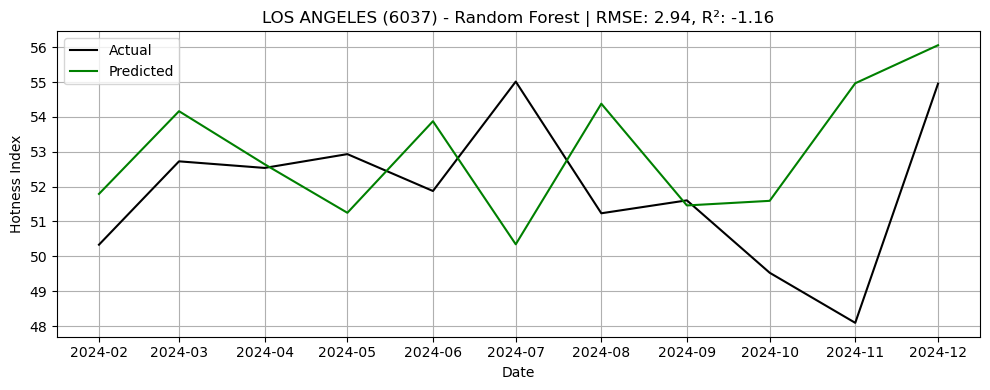

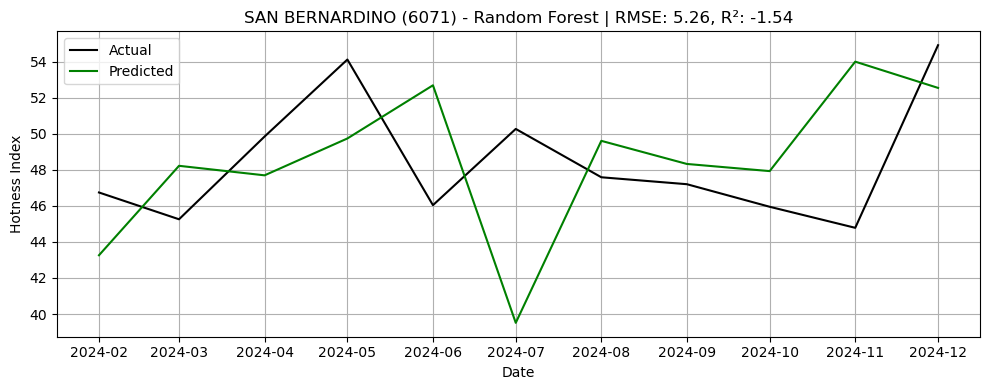

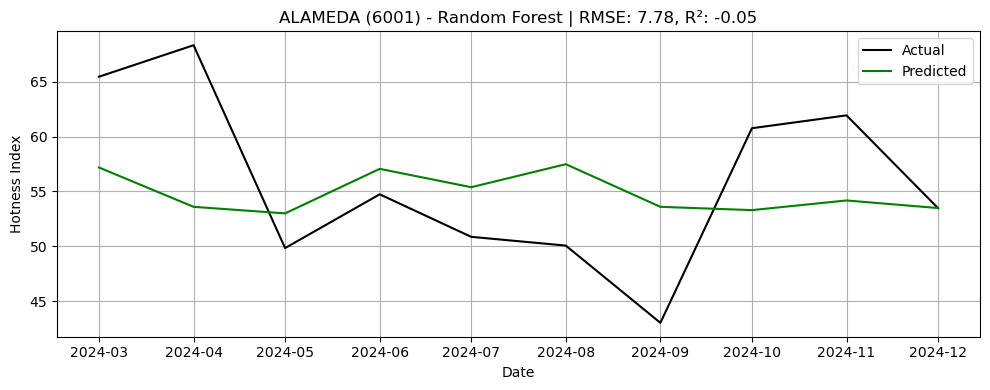

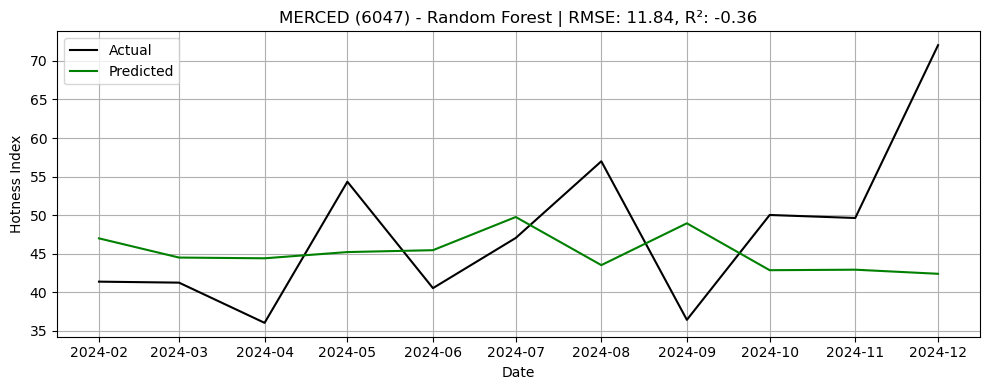

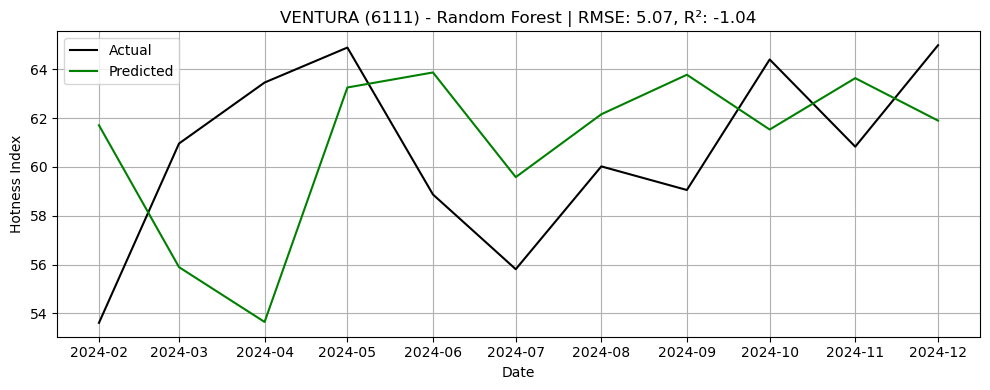

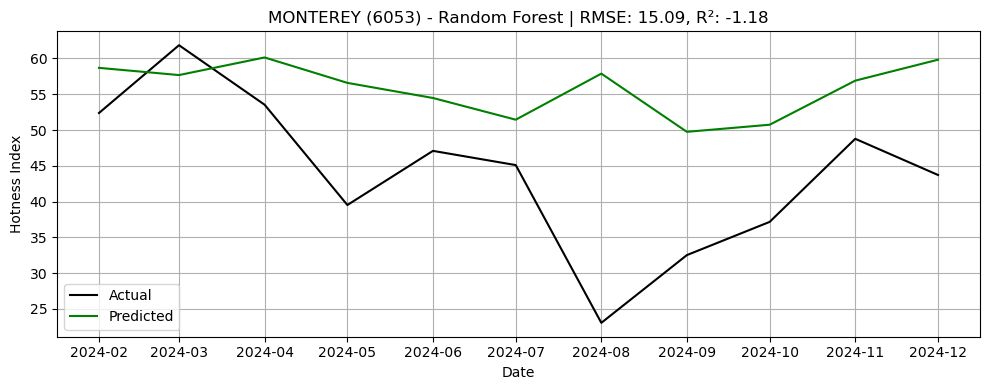

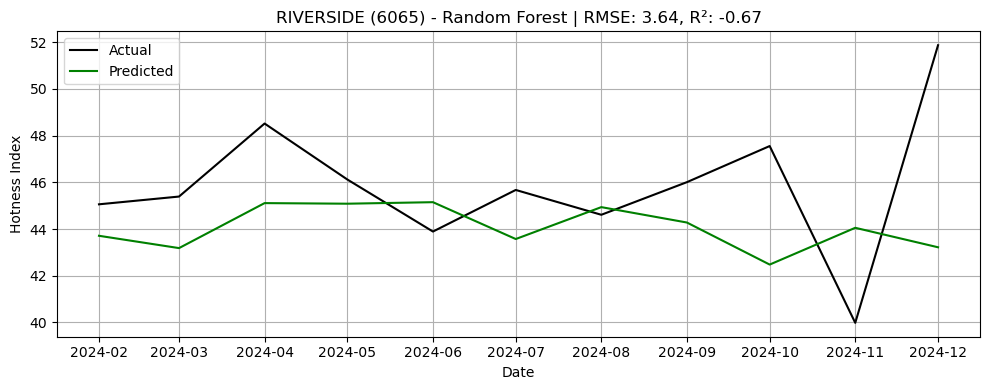

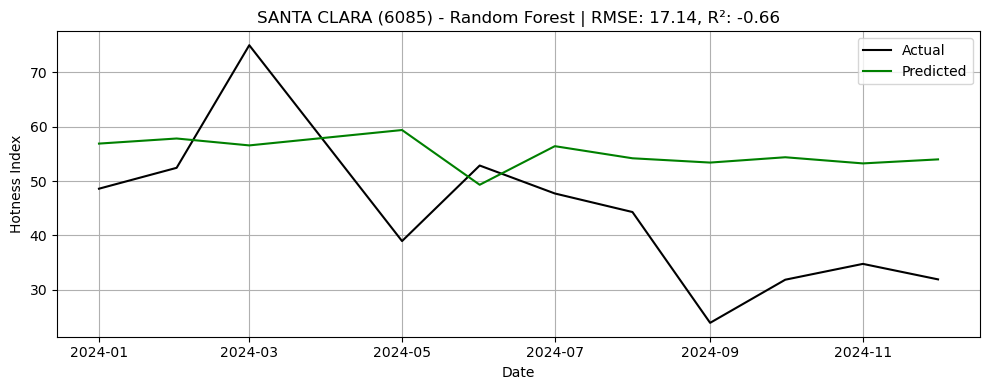

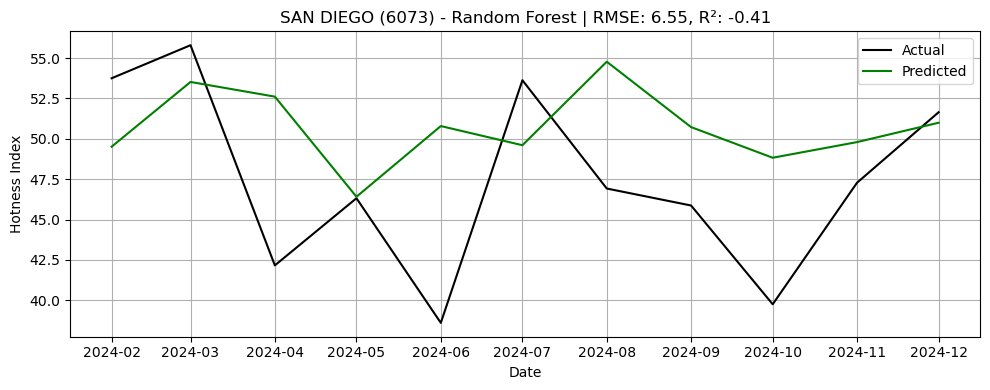

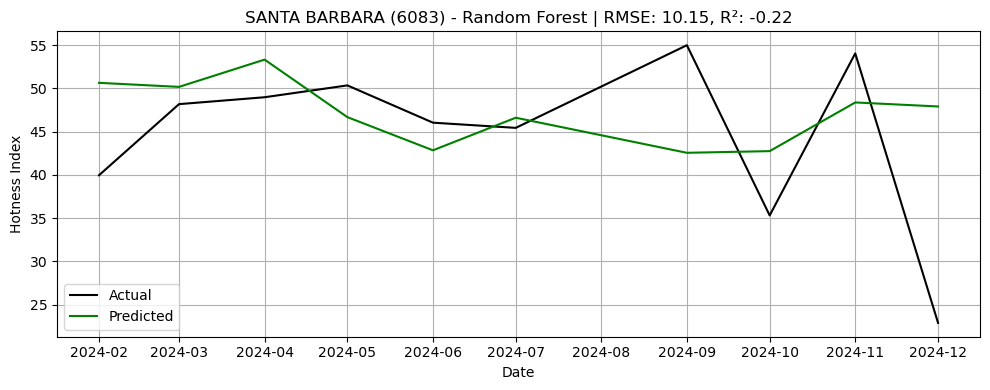

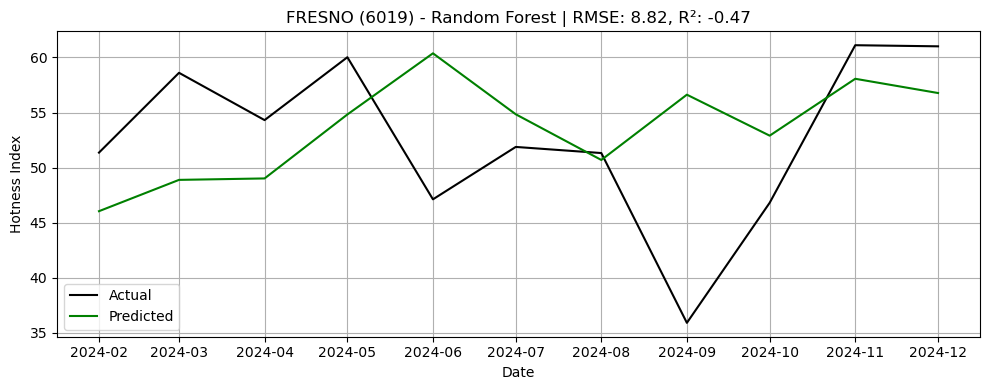

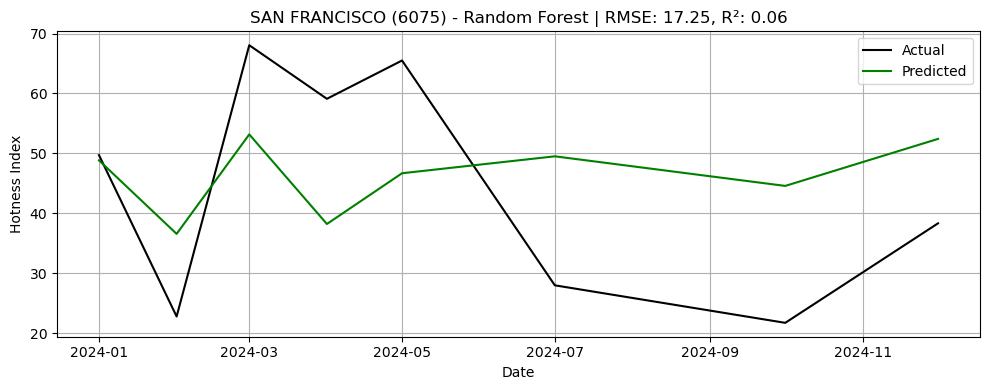

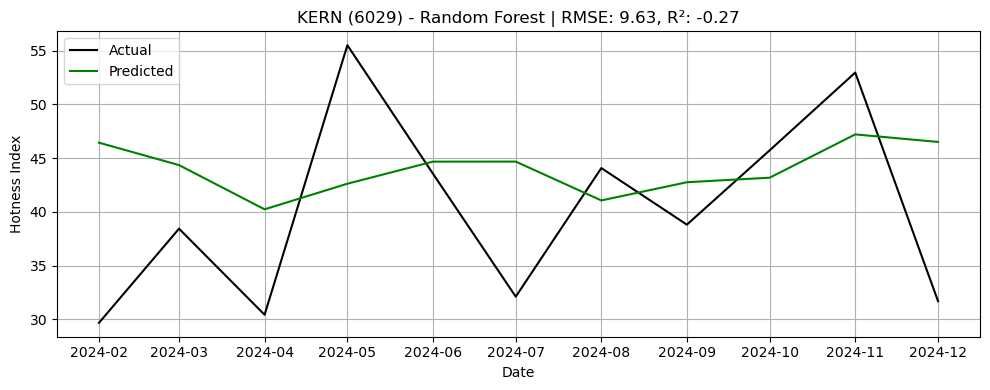

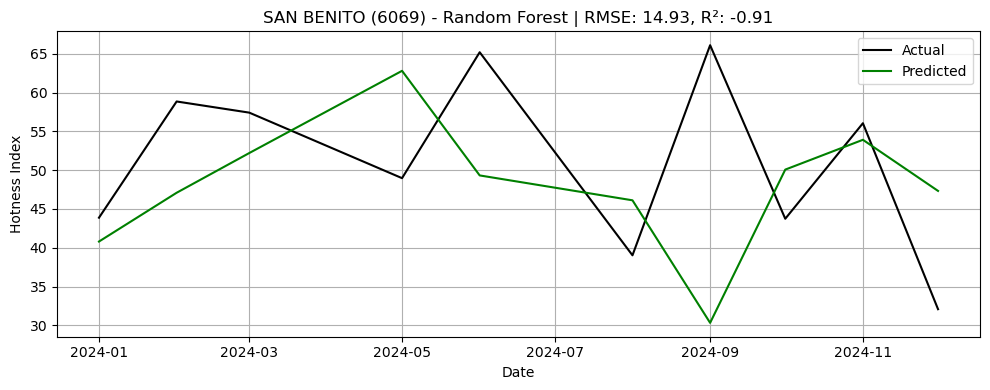

    county         cntyname       rmse        r2
9     6071   SAN BERNARDINO   5.259792 -1.536004
13    6053         MONTEREY  15.093264 -1.178288
8     6037      LOS ANGELES   2.944952 -1.156084
2     6039           MADERA  10.080495 -1.120771
12    6111          VENTURA   5.065722 -1.042918
5     6087       SANTA CRUZ  20.499615 -1.035304
21    6069       SAN BENITO  14.932984 -0.907757
4     6079  SAN LUIS OBISPO  15.629345 -0.743394
3     6081        SAN MATEO  16.226324 -0.704506
14    6065        RIVERSIDE   3.639180 -0.673754
15    6085      SANTA CLARA  17.139437 -0.662861
18    6019           FRESNO   8.818313 -0.468202
6     6059           ORANGE   4.571925 -0.462741
0     6007            BUTTE   8.532043 -0.461909
16    6073        SAN DIEGO   6.550367 -0.408510
11    6047           MERCED  11.838111 -0.364938
1     6033             LAKE  14.019648 -0.302613
20    6029             KERN   9.633572 -0.271753
17    6083    SANTA BARBARA  10.149267 -0.220663
7     6013     CONTR

In [8]:

# Define features
features = ['median_salelistratio_lag6',
             'median_dom_lag1', 
             'median_dom_lag6',
             'absorption_lag1',
             'med_yearbuilt',
             'unemployment_rate']

#'avg_salelistratio', 'avg_dom', 

# Clean data
df1 = df.copy()
df_clean = df1.dropna(subset=['hotness_index_lag1'] + features)
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean = df_clean[(df_clean['date'] >= '2020-02-02') & (df_clean['date'] <= '2025-02-02')]

# Store results
results_list = []

# Loop per county
for county in df_clean['cntycd'].unique():
    df_c = df_clean[df_clean['cntycd'] == county].sort_values('date')

    if len(df_c) < 36:
        continue

    cntyname = df_c['cntyname'].iloc[0]  # grab name from the first row

    # Split data
    split_idx = int(len(df_c) * 0.8)
    train = df_c.iloc[:split_idx].copy()
    test = df_c.iloc[split_idx:].copy()

    X_train = train[features]
    y_train = train['hotness_index']
    X_test = test[features]
    y_test = test['hotness_index']

    try:
        model = rfr(n_estimators=100, min_samples_leaf=2, min_samples_split=2, max_depth=10)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = root_mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results_list.append({'county': county, 'cntyname': cntyname, 'rmse': rmse, 'r2': r2})

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(test['date'], y_test.values, label='Actual', color='black')
        plt.plot(test['date'], preds, label='Predicted', color='green')
        plt.title(f'{cntyname} ({county}) - Random Forest | RMSE: {rmse:.2f}, R²: {r2:.2f}')
        plt.xlabel('Date')
        plt.ylabel('Hotness Index')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"County {county} failed: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)
print(results_df.sort_values('r2'))
